# Data Sourcing

This code queries the GitHub Code Search API to identify open-source repositories that likely use LLM-based tooling, patterns, or frameworks.

We define a curated list of **LLM-related keywords** covering:

* OpenAI API usage (`openai.ChatCompletion.create`)
* Prompting structures (`"prompt = "`, `"system":`)
* Frameworks like LangChain, llama.cpp, AutoGPT
* Retrieval-augmented generation libraries (e.g., FAISS, Chroma)

For each keyword, we retrieve up to **`max_pages × per_page`** results from GitHub’s Code Search API, filtering for Python files. Each result is a code file matched to the keyword, and we collect the:

* **Repository name**
* **File path**
* **URL to the matching file**
* **Matching keyword**

These are grouped by repository. For each repository, we track:

* All matched keywords (as a signal of LLM usage diversity)
* All matching file paths and URLs

This allows us to:

* **Filter for repositories with stronger LLM relevance** (based on keyword match count)
* Generate a dataset of repositories likely to contain rich prompt engineering artifacts

The final output is saved to:

* `data/matched_repositories.csv` (tabular)
* `data/matched_repositories.json` (structured)

This dataset will serve as the starting point for further analysis of prompt artifacts and their relationship to project activity and collaboration.


In [4]:
# Check and install required packages
import sys
import subprocess

def install_if_missing(package, import_name=None):
    try:
        __import__(import_name or package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Required packages
install_if_missing("requests")
install_if_missing("pandas")
install_if_missing("python-dotenv", import_name="dotenv")

Installing python-dotenv...
  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Using cached python_dotenv-1.1.1-py3-none-any.whl (20 kB)


In [6]:
import requests
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import os
import json
import time

# Load environment variables (e.g., GitHub token)
load_dotenv()
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")

# GitHub Search API endpoint
SEARCH_URL = "https://api.github.com/search/code"

# Expanded list of LLM-related keywords
keywords = [
    "openai.ChatCompletion.create", "openai.Completion.create",
    "PromptTemplate", "LLMChain", "ConversationChain", "RetrievalQA",
    "from langchain.llms", "from langchain.chat_models",
    "llama_cpp", "llamacpp", "llm.predict",
    "\"prompt = \"", "\"prompt=\"", "\"prompt\": \"", "\"system\": \"",
    "AutoGPT", "CrewAI", "AgentGPT", "BabyAGI",
    "ChatOpenAI", "Anthropic", "Claude", "HuggingFaceHub", "transformers.pipeline",
    "FAISS", "Chroma", "vectordb"
]

# GitHub headers
headers = {"Accept": "application/vnd.github.v3+json"}
if GITHUB_TOKEN:
    headers["Authorization"] = f"token {GITHUB_TOKEN}"

# Output paths
csv_path = Path("..") / "data" / "matched_repositories.csv"
json_path = Path("..") / "data" / "matched_repositories.json"
csv_path.parent.mkdir(parents=True, exist_ok=True)

# Store results per repository
repo_matches = {}

# Search GitHub for each keyword
max_pages = 5  # You can increase this to 10 (500 results per keyword max)
per_page = 50

for keyword in keywords:
    print(f"\n=== Searching for: {keyword} ===")
    for page in range(1, max_pages + 1):
        print(f"Page {page}")
        params = {
            "q": f"{keyword} in:file language:Python",
            "sort": "indexed",
            "order": "desc",
            "per_page": per_page,
            "page": page
        }
        try:
            r = requests.get(SEARCH_URL, headers=headers, params=params)
            r.raise_for_status()

            # Respect the 30-requests-per-minute limit
            remaining = int(r.headers.get("X-RateLimit-Remaining", 1))
            if remaining < 2:
                reset_time = int(r.headers.get("X-RateLimit-Reset", 0))
                sleep_for = max(1, reset_time - int(time.time()))
                print(f"Rate limit reached, sleeping for {sleep_for} s")
                time.sleep(sleep_for + 1)
            else:
                time.sleep(2)

            data = r.json()
            if not data.get("items"):
                print("No more results.")
                break

            for item in data["items"]:
                repo = item["repository"]["full_name"]
                if repo not in repo_matches:
                    repo_matches[repo] = {
                        "repository": repo,
                        "html_urls": set(),
                        "file_paths": set(),
                        "keywords": set()
                    }
                repo_matches[repo]["html_urls"].add(item["html_url"])
                repo_matches[repo]["file_paths"].add(item["path"])
                repo_matches[repo]["keywords"].add(keyword)

        except requests.exceptions.RequestException as e:
            print(f"Failed for {keyword} page {page}: {e}")
            break

# Flatten to DataFrame
records = []
for repo_data in repo_matches.values():
    records.append({
        "repository": repo_data["repository"],
        "keyword_count": len(repo_data["keywords"]),
        "keywords_matched": sorted(repo_data["keywords"]),
        "files_matched": sorted(repo_data["file_paths"]),
        "sample_urls": sorted(repo_data["html_urls"])[:3]
    })

df = pd.DataFrame(records).sort_values(by="keyword_count", ascending=False)

# Save CSV and JSON
df.to_csv(csv_path, index=False)
df.to_json(json_path, orient="records", indent=2)

# Summary
print(f"\nSaved {len(df)} repositories grouped by relevance:")
print(f"- CSV: {csv_path}")
print(f"- JSON: {json_path}")

# Display top matches
df[["repository", "keyword_count", "keywords_matched"]].head(10)




=== Searching for: openai.ChatCompletion.create ===
Page 1
Page 2
Page 3
Page 4
Page 5

=== Searching for: openai.Completion.create ===
Page 1
Page 2
Page 3
Page 4
Rate limit reached, sleeping for 40 s
Page 5

=== Searching for: PromptTemplate ===
Page 1
Page 2
Page 3
Page 4
Page 5

=== Searching for: LLMChain ===
Page 1
Page 2
Page 3
Rate limit reached, sleeping for 38 s
Page 4
Page 5

=== Searching for: ConversationChain ===
Page 1
Page 2
Page 3
Page 4
Page 5

=== Searching for: RetrievalQA ===
Page 1
Page 2
Rate limit reached, sleeping for 39 s
Page 3
Page 4
Page 5

=== Searching for: from langchain.llms ===
Page 1
Page 2
Page 3
Page 4
Page 5

=== Searching for: from langchain.chat_models ===
Page 1
Rate limit reached, sleeping for 38 s
Page 2
Page 3
Page 4
Page 5

=== Searching for: llama_cpp ===
Page 1
Page 2
Page 3
Page 4
Page 5
Rate limit reached, sleeping for 38 s

=== Searching for: llamacpp ===
Page 1
Page 2
Page 3
Page 4
Page 5

=== Searching for: llm.predict ===
Page 1
Pag

,repository,keyword_count,keywords_matched
756,hidevscommunity/gen-ai-apps,5,"[AutoGPT, HuggingFaceHub, LLMChain, RetrievalQ..."
652,ayusuf9/Augment-Chains,4,"[FAISS, PromptTemplate, RetrievalQA, from lang..."
604,jaredcrace/cracecasts,4,"[Chroma, LLMChain, PromptTemplate, llamacpp]"
1692,himanshu662000/InfoGPT,4,"[ChatOpenAI, Chroma, from langchain.chat_model..."
65,amaze18/speeKAR,4,"[FAISS, from langchain.chat_models, from langc..."
3713,scodecs/conversational-search-app,4,"[ChatOpenAI, FAISS, HuggingFaceHub, vectordb]"
609,aws-samples/private-llm-qa-bot,4,"[Anthropic, Claude, LLMChain, PromptTemplate]"
1277,frankstallone/notion-qa,4,"[ChatOpenAI, FAISS, RetrievalQA, from langchai..."
28,Tech-Abhang/LangChain-Basics,4,"[LLMChain, RetrievalQA, from langchain.chat_mo..."
1421,kingly123/My_AI,4,"[FAISS, HuggingFaceHub, from langchain.chat_mo..."


### Further Analysis

Repositories by number of matched keywords:

1 keyword(s): 4763 repository(ies)
2 keyword(s): 407 repository(ies)
3 keyword(s): 62 repository(ies)
4 keyword(s): 23 repository(ies)
5 keyword(s): 1 repository(ies)


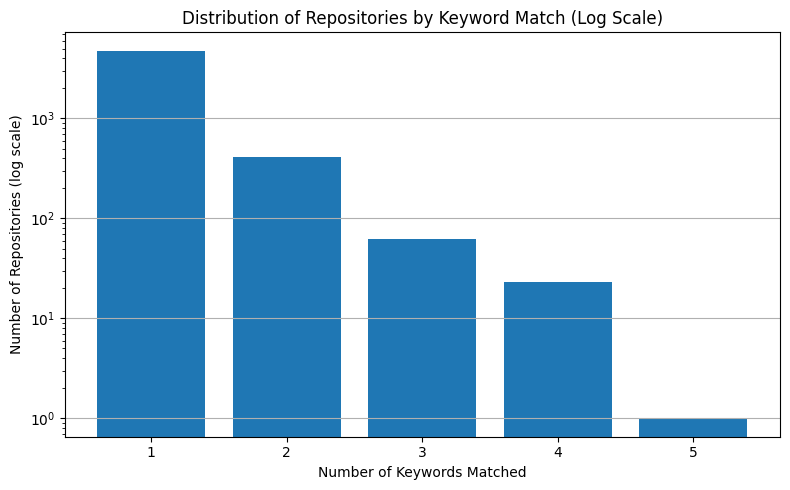

In [ ]:
import matplotlib.pyplot as plt

# Count number of repositories per keyword_count category
keyword_count_distribution = df["keyword_count"].value_counts().sort_index()

# Print distribution
print("Repositories by number of matched keywords:\n")
for count, num_repos in keyword_count_distribution.items():
    print(f"{count} keyword(s): {num_repos} repository(ies)")

plt.figure(figsize=(8, 5))
df["keyword_count"].plot(
    kind="hist",
    bins=range(1, df["keyword_count"].max() + 2),
    rwidth=0.8,
    align="left",
    log=True  # Log scale
)
plt.title("Distribution of Repositories by Keyword Match (Log Scale)")
plt.xlabel("Number of Keywords Matched")
plt.ylabel("Number of Repositories (log scale)")
plt.xticks(range(1, df["keyword_count"].max() + 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()



*Note: Code and text generated by gpt-4o*